# Import Library

In [43]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Melakukan import seluruh library yang dibutuhkan, mulai dari mengolah data, visualisasi, prapemrosesan data, hingga pembangunan dan pelatihan model machine learning sistem rekomendasi baik content-based filtering (TF-IDF & Cosine)maupun collaborative filtering

# Data Loading

In [44]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

<ipython-input-44-84da3ecd6207>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


Melakukan load tiga file utama secara lokal dari dataset rekomendasi buku, yaitu Books.csv (data buku), Ratings.csv (data rating pengguna), dan Users.csv (data pengguna) untuk keperluan analisis dan pembuatan sistem rekomendasi.

In [45]:
print('Jumlah data buku: ', len(books.ISBN.unique()))
print('Jumlah data penilaian buku: ', len(ratings))
print('Jumlah data pengguna: ', len(users['User-ID'].unique()))

Jumlah data buku:  271360
Jumlah data penilaian buku:  1149780
Jumlah data pengguna:  278858


Menampilkan jumlah data masing-masing dari buku (berdasarkan ISBN), data penilaian atau rating, dan jumlah pengguna (berdasarkan User-ID) yang terdapat dalam dataset.

# Exploratory Data Analysis (EDA)

## Mengeksplorasi Data Buku

In [46]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Menampilkan ringkasan informasi dari data buku mulai dari kolom, jumlah baris, dan tipe data tiap kolomnya. Terlihat ada 8 kolom dengan jumlah baris 271.360 baris data dan semua tipe data kolomnya adalah object.

In [47]:
print('Banyak data: ', len(books.ISBN.unique()))

print('Total Author unik:', books['Book-Author'].nunique())
print('Beberapa Author:', books['Book-Author'].unique()[:10])

print('Total Tahun Publikasi unik:', books['Year-Of-Publication'].nunique())
print('Beberapa Tahun Publikasi:', books['Year-Of-Publication'].unique()[:10])

print('Total Publisher unik:', books['Publisher'].nunique())
print('Beberapa Publisher:', books['Publisher'].unique()[:10])

Banyak data:  271360
Total Author unik: 102022
Beberapa Author: ['Mark P. O. Morford' 'Richard Bruce Wright' "Carlo D'Este"
 'Gina Bari Kolata' 'E. J. W. Barber' 'Amy Tan' 'Robert Cowley'
 'Scott Turow' 'David Cordingly' 'Ann Beattie']
Total Tahun Publikasi unik: 202
Beberapa Tahun Publikasi: [2002 2001 1991 1999 2000 1993 1996 1988 2004 1998]
Total Publisher unik: 16807
Beberapa Publisher: ['Oxford University Press' 'HarperFlamingo Canada' 'HarperPerennial'
 'Farrar Straus Giroux' 'W. W. Norton &amp; Company' 'Putnam Pub Group'
 'Berkley Publishing Group' 'Audioworks' 'Random House' 'Scribner']


Menampilkan total jumlah buku berdasarkan ISBN unik, serta menghitung banyaknya penulis, tahun terbit, dan penerbit yang berbeda. Ditampilkan juga beberapa contoh nilai dari tiap kolom untuk memberikan ilustrasi isi data.

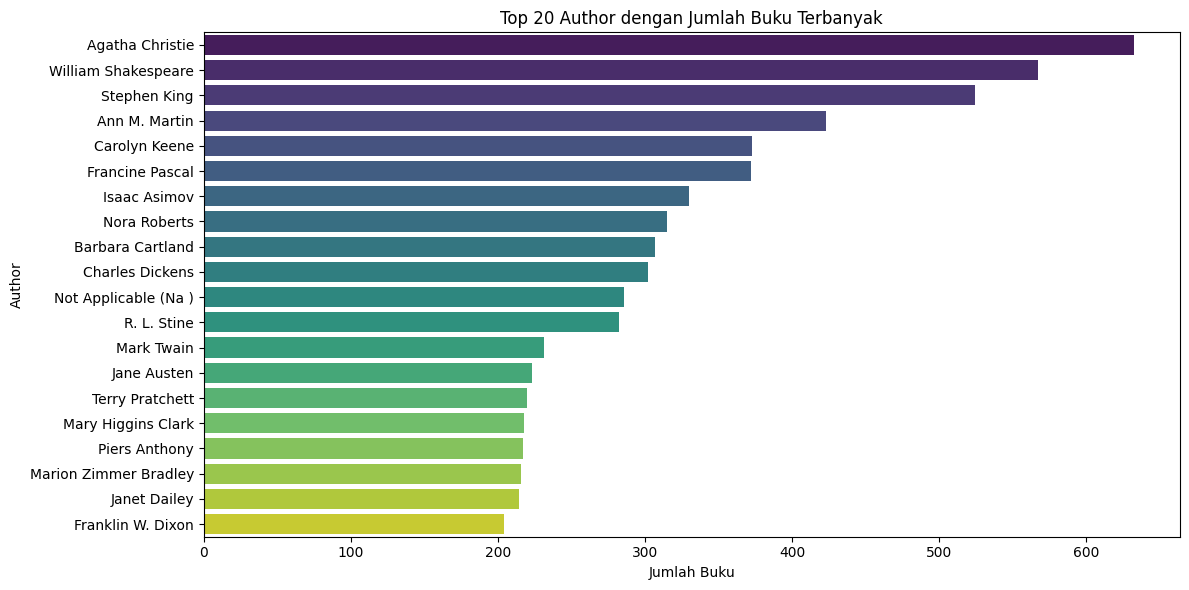

In [48]:
# Top 20 Author dengan jumlah buku terbanyak
top_authors = books['Book-Author'].value_counts().head(20).reset_index()
top_authors.columns = ['Author', 'Jumlah Buku']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_authors, x='Jumlah Buku', y='Author', hue='Author', palette='viridis', legend=False)
plt.title('Top 20 Author dengan Jumlah Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

Menampilkan visualisasi 20 author teratas dengan jumlah buku terbanyak dalam dataset. Data dihitung berdasarkan frekuensi nama penulis, kemudian divisualisasikan dalam bentuk barplot horizontal. Terlihat dalam barplot tersebut author teratas adalah Agatha Christie, lalu William Shakespeare, disusul Stephen King dan seterusnya.

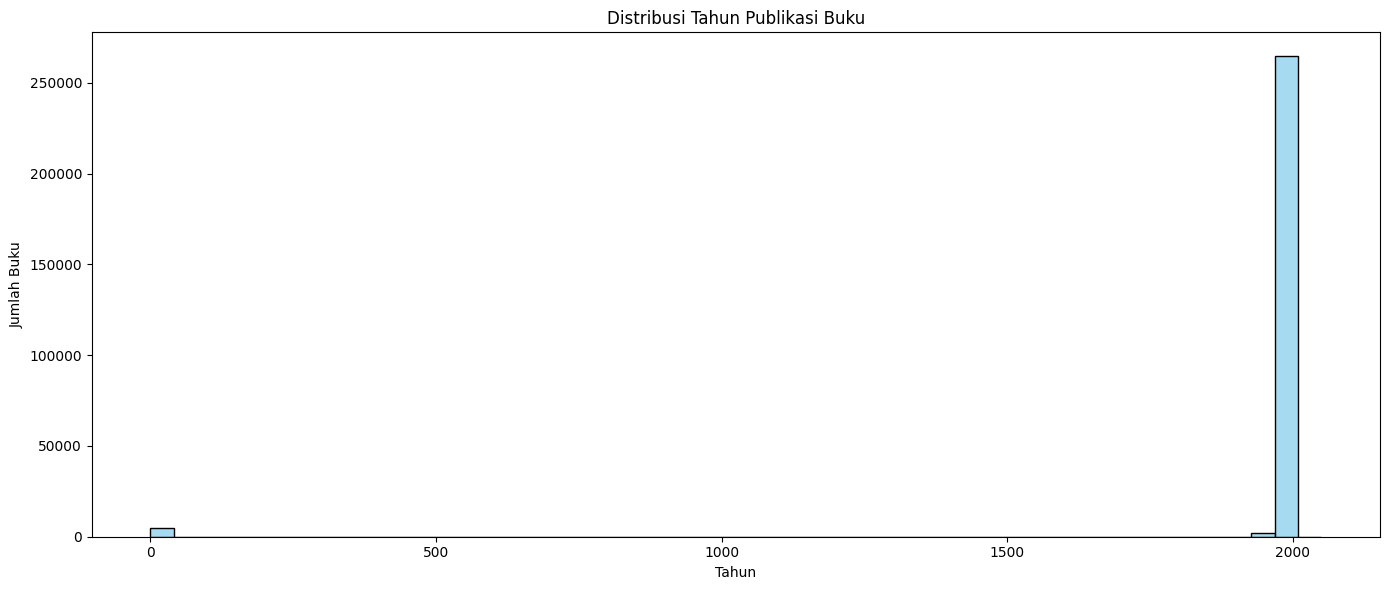

In [49]:
# Konversi tahun jadi angka (untuk menghindari kesalahan parsing)
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

plt.figure(figsize=(14, 6))
sns.histplot(books['Year-Of-Publication'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribusi Tahun Publikasi Buku')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Buku')
plt.tight_layout()
plt.show()

Menunjukkan visualisasi distribusi jumlah buku berdasarkan tahun publikasi. Data tahun terlebih dahulu dikonversi ke format numerik untuk menghindari error, lalu divisualisasikan menggunakan histogram. Terlihat bahwa sebagian besar buku dipublikasikan pada rentang tahun 1900 ke atas, dengan outlier di tahun-tahun ekstrem seperti 0 atau di luar rentang wajar. Sehingga, variabel ini mungkin tidak akan dipertimbangkan untuk digunakan dalam fitur pemodelan.

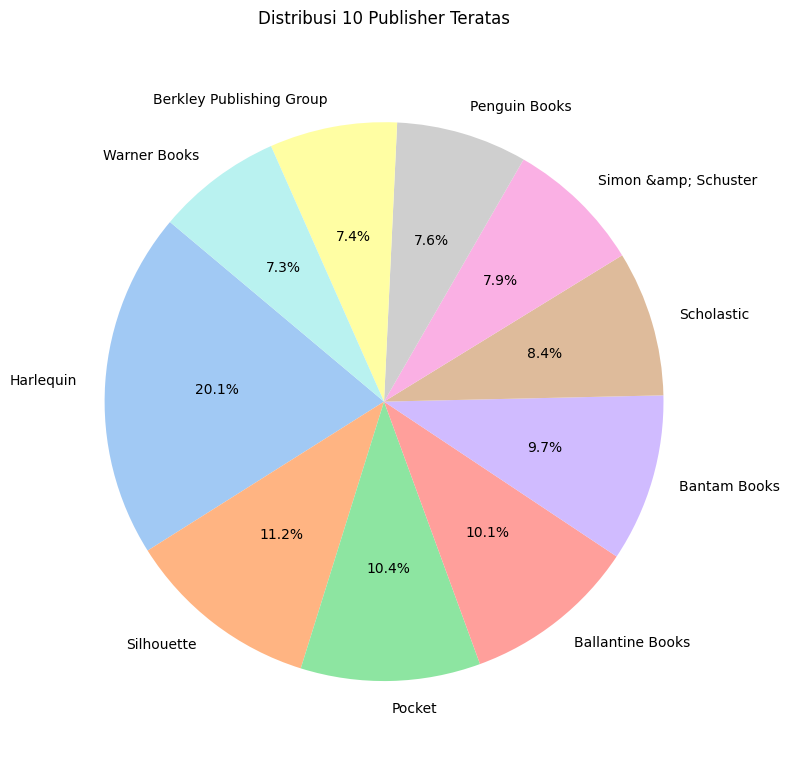

In [50]:
top_publishers = books['Publisher'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_publishers.values, labels=top_publishers.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribusi 10 Publisher Teratas')
plt.axis('equal')
plt.tight_layout()
plt.show()

Visualisasi pie chart ini menunjukkan distribusi sepuluh penerbit buku teratas berdasarkan jumlah buku yang diterbitkan. Harlequin menjadi penerbit dengan kontribusi terbanyak sebesar 20.1%.

## Mengeksplorasi Data Rating

In [51]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Menampilkan ringkasan informasi dari data rating pengguna terhadap buku pada dataframe "ratings" mulai dari kolom, jumlah baris, dan tipe data tiap kolomnya. Terlihat ada 3 kolom dengan jumlah baris 1.149.780 baris data dengan 2 kolom bertipe data numerik (int64), dan 1 kolom bertipe data object.

In [52]:
print('Jumlah data user: ', len(ratings['User-ID'].unique()))
print('Jumlah data buku: ', len(ratings['ISBN'].unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah data user:  105283
Jumlah data buku:  340556
Jumlah data rating:  1149780


Menampilkan jumlah data unik tiap kolom, mulai dari user (User-ID), buku (ISBN), dan rating (Book-Rating).

In [53]:
pd.set_option('display.float_format', '{:.2f}'.format)
print(ratings.describe())

         User-ID  Book-Rating
count 1149780.00   1149780.00
mean   140386.40         2.87
std     80562.28         3.85
min         2.00         0.00
25%     70345.00         0.00
50%    141010.00         0.00
75%    211028.00         7.00
max    278854.00        10.00


Menampilkan statistik deskriptif dari variabel numerik data rating, seperti nilai minimum, maksimum, rata-rata, dan kuartil yang digunakan untuk memahami sebaran nilai rating secara umum. Namun, pertama dilakukan pengaturan format tampilan angka desimal menjadi dua digit di belakang koma

## Mengeksplorasi Data User

In [54]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Menampilkan ringkasan informasi dari data pengguna pada dataframe "users" mulai dari kolom, jumlah baris, dan tipe data tiap kolomnya. Terlihat ada 3 kolom dengan jumlah baris 278.858 baris data dengan 2 kolom bertipe data numerik (int64 dan float64), dan 1 kolom bertipe data object.

In [55]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN


Menampilkan contoh data users yang terdiri dari id, lokasi pengguna, dan usia pengguna. Namun, fitur-fitur ini tidak kami gunakan dalam studi kasus sistem rekomendasi kali ini, karena yang akan digunakan adalah berdasarkan item (fitur buku) bukan user (demografi pengguna).

# Data Preparation

## Menggabungkan Seluruh Data

In [56]:
all_books_rate = ratings
all_books_rate

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


Membuat dataframe "all_books_rate" yang merupakan salinan dari dataframe "ratings" dan menampilkan contoh isinya.

In [57]:
all_books = pd.merge(all_books_rate, books[['ISBN','Book-Title','Book-Author', 'Publisher']], on='ISBN', how='left')
all_books

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
...,...,...,...,...,...,...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,Jove Books
1149778,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,Scholastic


Melakukan penggabungan atau join antara dataframe "all_books_rate" yang dibuat sebelumnya dan informasi buku dari books berdasarkan kolom ISBN menggunakan metode left join. Hasilnya adalah DataFrame all_books yang berisi rating buku lengkap dengan judul, penulis, dan penerbitnya.

## Menangani Missing Value

In [58]:
# Mengecek missing value pada dataframe all_books
all_books.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,118644
Book-Author,118646
Publisher,118646


Melakukan pengecekan missing value pada DataFrame all_books yang merupakan hasil penggabungan sebelumnya antara data rating dengan informasi detail buku seperti judul, penulis, dan penerbit. Terlihat ada beberapa missing value di kolom seperti judul, author, dan publisher.

Missing value yang muncul merupakan hal wajar karena proses penggabungan dilakukan dengan left join, sehingga tidak semua ISBN pada rating memiliki data lengkap di tabel buku. Oleh karena itu, baris yang memiliki missing value akan dibuang agar tidak memengaruhi hasil analisis dan sistem rekomendasi.

In [59]:
# Membersihkan missing value dengan fungsi dropna()
all_books_clean = all_books.dropna()
all_books_clean

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
...,...,...,...,...,...,...
1149774,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,A.R.E. Press (Association of Research &amp; Enlig
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,Longstreet Press
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,Alfred A. Knopf
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,Jove Books


Melakukan drop atau membuang baris yang memiliki missing value dan menyimpannya pada dataframe "all_books_clean".

In [60]:
# Mengecek missing value pada dataframe all_books
all_books_clean.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0
Book-Title,0
Book-Author,0
Publisher,0


Melakukan pengecekan kembali hasil penghapusan baris dengan missing value tadi.

## Menangani Data Duplikat pada ISBN

In [61]:
preparation = all_books_clean.drop_duplicates('ISBN')
preparation

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
...,...,...,...,...,...,...
1149701,276688,0517145553,0,Mostly Harmless,Douglas Adams,Random House Value Pub
1149747,276688,1575660792,7,Gray Matter,Shirley Kennett,Kensington Publishing Corporation
1149757,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,Apple
1149770,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,Vintage Books USA


Pada tahap ini, dilakukan penanganan duplikat pada kolom ISBN, karena pada pemodelan content-based filtering nanti diperlukan representasi unik untuk setiap buku. Duplikasi dapat menyebabkan bias dalam perhitungan kemiripan antar buku, sehingga perlu dihapus agar hasil rekomendasi lebih akurat. Hasilnya disimpan pada dataframe "preparation".

## Mengambil 10.000 data acak

In [62]:
preparation = preparation.sample(frac=1, random_state=42).reset_index(drop=True)
preparation = preparation[:10000]

Pada tahap ini, data diambil sebanyak 10.000 saja secara acak menggunakan random_state untuk memastikan hasil yang konsisten. Hal ini dilakukan untuk mengurangi ukuran data karena keterbatasan sumber daya pengolahan data serta demi efisiensi proses pelatihan model tanpa mengorbankan keragaman sampel.

## Membuat Dictionary

In [63]:
# Mengonversi data series ISBN menjadi dalam bentuk list
book_id = preparation['ISBN'].tolist()

# Mengonversi data series Book-Title menjadi dalam bentuk list
book_title = preparation['Book-Title'].tolist()

# Mengonversi data series Book-Author menjadi dalam bentuk list
book_author = preparation['Book-Author'].tolist()

# Mengonversi data series Publisher menjadi dalam bentuk list
book_publisher = preparation['Publisher'].tolist()

print(len(book_id))
print(len(book_title))
print(len(book_author))
print(len(book_publisher))

10000
10000
10000
10000


Pada tahap ini, data dari beberapa kolom seperti ISBN, judul buku, penulis, dan penerbit dikonversi menjadi bentuk list. Hal ini bertujuan untuk mempermudah proses pemetaan atau manipulasi data pada tahap selanjutnya.

In [64]:
# Membuat dictionary untuk data "book_id", "book_title", "book_author", "book_publisher"
books_new = pd.DataFrame({
    'id' : book_id,
    'title' : book_title,
    'author' : book_author,
    'publisher' : book_publisher
})

books_new

,id,title,author,publisher
0,0761300635,The Right to Speak Out (Land of the Free (Broo...,David C. King,Millbrook Press
1,0881843466,Science Fiction: The 100 Best Novels : An Engl...,David Pringle,Pub Group West
2,0671885642,The THIRD HORROR (99 FEAR STREET 3) : THE THIR...,R.L. Stine,Simon Pulse
3,1575211750,Apache Server Survival Guide,Manuel Alberto Ricart,Sams
4,0515125253,State of Emergency,Steve Pieczenik,Jove Books
...,...,...,...,...
9995,0765308029,The Ethos Effect,L. E. Modesitt Jr.,Tor Books
9996,0873378504,Nolo's Patents for Beginners (Nolo's Patents f...,David Pressman,Nolo Press
9997,0821740903,Love and Glory (Zebra books),Joyce Myrus,Kensington Pub Corp (Mm)
9998,0689821646,The MOORCHILD,Eloise McGraw,Aladdin


Data yang sudah dikonversi ke dalam bentuk list sebelumnya kemudian disatukan kembali ke dalam sebuah dictionary yaitu DataFrame baru bernama books_new. DataFrame ini memuat informasi utama buku seperti ID, judul, penulis, dan penerbit yang siap digunakan untuk pemodelan atau analisis selanjutnya.

# Model Development Content-Based Filtering

In [65]:
data = books_new
data.sample(5)

,id,title,author,publisher
6985,0373709536,"Christmas Babies (Twins) (Superromance, 953)",Ellen James,Harlequin
5318,006025081X,Addie Runs Away (Early I Can Read Book),Joan Robins,HarperCollins Publishers
6495,0142437220,The Divine Comedy: Inferno (Penguin Classics),Dante Alighieri,Penguin Books
7249,0385468520,Alley Kat Blues (Kat Colorado Mysteries),Karen Kijewski,Doubleday Books
1462,0449907945,Ordinary Love and Good Will : Two Novellas,JANE SMILEY,Ballantine Books


Menyalin data yang ada pada dataframe "books_new" ke dalam dataframe salinan baru, yaitu "data" dan menampilkan 5 sampel data tersebut.

In [66]:
data['combined'] = (
    data['title'].fillna('') + ' ' +
    data['author'].fillna('') + ' ' +
    data['publisher'].fillna('')
)

Pada tahap ini, dilakukan penggabungan tiga kolom penting dalam data—yaitu title, author, dan publisher—menjadi satu kolom baru bernama combined. Tujuan dari langkah ini adalah untuk membuat representasi teks gabungan dari informasi buku, yang nantinya bisa digunakan untuk pemodelan berbasis konten (content-based filtering), seperti TF-IDF dan cosine similarity.

In [67]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        return text
    return ""

data['cleaned'] = data['combined'].apply(clean_text)

Pada tahap ini, dilakukan pembersihan teks dengan menghapus tanda baca dan mengubah semua huruf menjadi huruf kecil serta mengembalikan string kosong jika input bukan tipe string (menghindari error). Proses ini diterapkan pada kolom combined dan hasilnya disimpan di kolom cleaned. Tujuannya adalah untuk menyiapkan data teks yang konsisten sebelum dilakukan proses vektorisasi.

In [68]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['cleaned'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(10000, 20646)

Pada tahap ini, dilakukan proses vektorisasi terhadap teks yang sudah dibersihkan menggunakan TF-IDF untuk mengubah data teks menjadi representasi numerik. Stop words dalam bahasa Inggris dihapus agar hasil lebih relevan. Selanjutnya, ditampilkan ukuran matriks TF-IDF yang terbentuk, yang merepresentasikan jumlah data dan kata unik dari seluruh data.

In [69]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.04431404, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04431404, 1.        , 0.        , ..., 0.03788908, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03788908, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Pada tahap ini, dilakukan perhitungan cosine similarity terhadap matriks TF-IDF untuk mengukur tingkat kemiripan antar buku berdasarkan fitur teks gabungan (judul, penulis, dan penerbit). Hasilnya berupa matriks kesamaan yang menunjukkan seberapa mirip setiap buku dengan buku lainnya.

In [70]:
# Membuat DataFrame similarity dengan baris dan kolom berupa judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat sebagian dari similarity matrix antar buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10000, 10000)


title,Family Health &amp; Medical Guide,Night of the Hawk: A Saga of the Southwest Book V,Mary Anne and Miss Priss (Baby-Sitters Club (Paperback)),Haunted Traveller,Genuine Lies
title,,,,,
"Family Kind Of Wedding (That Special Woman/Forever Family) (Silhouette Special Edition, 1219)",0.14,0.00,0.00,0.00,0.00
Candide (Classics Collection),0.00,0.02,0.00,0.04,0.00
Montado En LA Bala,0.00,0.00,0.00,0.00,0.00
Psychology,0.00,0.00,0.00,0.00,0.00
"Firecross (Able Team, No 32)",0.00,0.00,0.00,0.00,0.00
Solitaire Mystery,0.00,0.00,0.00,0.04,0.00
Andalusien. Richtig reisen.,0.00,0.00,0.00,0.00,0.00
For Love Of Zach (Love Inspired (Numbered)),0.00,0.00,0.00,0.00,0.00
The Ranger (Zebra Historical Romance),0.00,0.01,0.00,0.00,0.00


Pada tahap ini, matriks cosine similarity dikonversi menjadi sebuah DataFrame dengan baris dan kolom berupa judul buku agar lebih mudah dianalisis. Kemudian, ditampilkan sebagian isi matriks tersebut secara acak untuk melihat nilai kemiripan antar judul buku dalam format yang terbaca.

In [85]:
def book_recommendations(judul_buku, similarity_data=cosine_sim_df, items=data[['title', 'author', 'publisher']], k=10):
    """
    Memberikan rekomendasi buku berdasarkan kemiripan konten (TF-IDF cosine similarity).
    """
    try:
        # Pastikan judul buku ada dan hanya satu
        if judul_buku not in similarity_data.columns:
            return f"Judul '{judul_buku}' tidak ditemukan dalam similarity data."

        # Ambil kolom sebagai Series, bukan DataFrame
        sim_scores = similarity_data.loc[:, judul_buku]

        # Pastikan Series, bukan DataFrame
        if isinstance(sim_scores, pd.DataFrame):
            sim_scores = sim_scores.iloc[:, 0]

        # Urutkan nilai similarity
        sim_scores = sim_scores.sort_values(ascending=False)

        # Buang dirinya sendiri
        sim_scores = sim_scores.drop(labels=[judul_buku], errors='ignore')

        # Ambil top-k index
        top_titles = sim_scores.head(k).index

        # Gabungkan dengan metadata
        return items[items['title'].isin(top_titles)].drop_duplicates('title').head(k)

    except Exception as e:
        return f"Terjadi error: {e}"

Membuat fungsi book_recommendations(). Fungsi book_recommendations() digunakan untuk memberikan rekomendasi buku berdasarkan kemiripan konten menggunakan metode TF-IDF dan cosine similarity. Fungsi ini mencari buku-buku yang paling mirip dengan judul yang diberikan, lalu mengurutkannya berdasarkan skor kemiripan tertinggi dan menampilkan sejumlah buku teratas yang direkomendasikan. Rekomendasi yang dihasilkan berupa informasi judul, penulis, dan penerbit dari buku-buku yang memiliki konten paling mirip.

In [86]:
data[data.title.eq("A Portrait of the Artist As a Young Man")]

,id,title,author,publisher,combined,cleaned
3786,0451525442,A Portrait of the Artist As a Young Man,James Joyce,Signet Book,A Portrait of the Artist As a Young Man James ...,a portrait of the artist as a young man james ...
4266,0679739890,A Portrait of the Artist As a Young Man,James Joyce,Vintage Books USA,A Portrait of the Artist As a Young Man James ...,a portrait of the artist as a young man james ...


Menampilkan baris data yang memiliki judul buku "A Portrait of the Artist As a Young Man" dalam kolom title.

In [87]:
book_recommendations("A Portrait of the Artist As a Young Man", k=10)

,title,author,publisher
570,A Man of Affairs (Signet Regency Romance),Anne Barbour,Signet Book
2390,The Nobody (Signet Regency Romance),Diane Farr,Signet Book
4427,George Bellows: American Artist (Writers on Art),Joyce Carol Oates,Harpercollins
4881,The Runaways (Signet Regency Romance),Barbara Hazard,Signet Book
6574,Dubliners,James Joyce,Signet Classics
7982,Dubliners (Essential.penguin S.),James Joyce,Penguin Books Ltd
8554,A London Season (Signet Regency Romance),Joan Wolf,Signet Book
9014,Impostress (Signet Historical Romance),Lisa Jackson,Signet Book
9062,Arabia-Una nubecilla-Duplicados,James Joyce,Sudamericana
9315,Gentleman Jack (Signet Regency Romance),Margaret Summerville,Signet Book


Memanggil fungsi book_recommendations untuk memberikan 5 rekomendasi buku yang mirip dengan "A Portrait of the Artist As a Young Man" berdasarkan kemiripan konten menggunakan cosine similarity dari TF-IDF.Output diatas merupakan hasil rekomendasi 5 buku yang mirip dengan buku "A Portrait of the Artist As a Young Man".

## 📊 Evaluasi Content-Based Filtering dengan Recall@10

Sistem rekomendasi dijalankan untuk buku **"A Portrait of the Artist As a Young Man"** dengan `k=10`, yang berarti menampilkan 10 rekomendasi teratas berdasarkan kemiripan konten (judul, penulis, penerbit).

Berikut adalah hasil rekomendasinya:

| No | Judul Buku                                              | Author              | Publisher           | Relevan? |
|----|----------------------------------------------------------|---------------------|---------------------|----------|
| 1  | A Man of Affairs (Signet Regency Romance)                | Anne Barbour        | Signet Book         | ✅       |
| 2  | The Nobody (Signet Regency Romance)                      | Diane Farr          | Signet Book         | ✅       |
| 3  | George Bellows: American Artist (Writers on Art)         | Joyce Carol Oates   | Harpercollins       | ❌       |
| 4  | The Runaways (Signet Regency Romance)                    | Barbara Hazard      | Signet Book         | ✅       |
| 5  | Dubliners                                                | James Joyce         | Signet Classics     | ✅       |
| 6  | Dubliners (Essential.penguin S.)                         | James Joyce         | Penguin Books Ltd   | ✅       |
| 7  | A London Season (Signet Regency Romance)                 | Joan Wolf           | Signet Book         | ✅       |
| 8  | Impostress (Signet Historical Romance)                   | Lisa Jackson        | Signet Book         | ✅       |
| 9  | Arabia-Una nubecilla-Duplicados                          | James Joyce         | Sudamericana        | ✅       |
|10  | Gentleman Jack (Signet Regency Romance)                  | Margaret Summerville| Signet Book         | ✅       |

**Kriteria relevansi**:
- **Penulis**: Sama (James Joyce)
- **Penerbit**: Sama atau sangat mirip (misalnya "Signet Book")

### ✅ Perhitungan Recall@10

Terdapat **10 rekomendasi** yang diberikan (`k=10`), dan dari daftar tersebut, **9 buku** dianggap **relevan** karena memiliki kemiripan penerbit atau penulis dengan buku sumber.

$$
Recall@10 = \frac{9}{10} = 0.90
$$


Dengan nilai **Recall@10 = 0.90**, dapat disimpulkan bahwa sistem mampu merekomendasikan buku-buku yang relevan dengan baik dalam 10 besar hasil.

---

# Model Development Collaborative Filtering

## Menyalin data rating dan mengambil 10.000 sampel data secara acak

In [74]:
# Ambil dataframe rating buku
df = ratings.copy()

# Mengacak dan mengambil 10.000 data saja
df = df.sample(frac=1, random_state=42).head(10000)
df

,User-ID,ISBN,Book-Rating
178554,38781,0373259131,0
533905,128835,0811805905,8
1091374,261829,037324486X,0
1036247,247747,0531303306,0
309523,74076,0316812404,0
...,...,...,...
1102648,264637,0671032615,0
1139784,274061,1892213001,10
201118,45113,0425102416,10
373373,89602,042516036X,0


Membuat salinan dari DataFrame ratings ke dalam DataFrame baru df. Selanjutnya, data diacak dan diambil sebanyak 10.000 baris secara acak untuk mengurangi ukuran data, demi efisiensi proses pelatihan model dan keterbatasan sumber daya komputasi.

## Melakukan encoding fitur

In [75]:
# Mengubah User-ID menjadi list unik
user_ids = df['User-ID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# Mengubah ISBN menjadi list unik
book_ids = df['ISBN'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

Pada tahap ini, dilakukan encoding terhadap kolom User-ID dan ISBN menjadi angka unik agar dapat digunakan dalam pelatihan model. Dictionary user_to_user_encoded dan book_to_book_encoded digunakan untuk mengubah ID asli ke bentuk numerik, sedangkan user_encoded_to_user dan book_encoded_to_book untuk mengubahnya kembali ke ID asli. Proses ini penting agar data dapat dimasukkan ke dalam model rekomendasi berbasis embedding.

In [76]:
# Mapping ke dataframe
df['user'] = df['User-ID'].map(user_to_user_encoded)
df['book'] = df['ISBN'].map(book_to_book_encoded)

Pada tahap ini, dataframe df dimapping menggunakan dictionary encoding yang telah dibuat sebelumnya. Kolom User-ID diubah menjadi kolom user, dan ISBN menjadi kolom book, yang masing-masing berisi representasi numerik dari ID asli. Proses ini merupakan lanjutan dari tahap sebelumnya untuk mempersiapkan data dalam format numerik yang dibutuhkan oleh model rekomendasi berbasis embedding TensorFlow.

In [77]:
# Convert rating ke float
df['rating'] = df['Book-Rating'].astype(np.float32)

# Info penting
num_users = len(user_ids)
num_books = len(book_ids)
min_rating = df['rating'].min()
max_rating = df['rating'].max()

print(f"Jumlah User: {num_users}, Jumlah Buku: {num_books}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Jumlah User: 5324, Jumlah Buku: 8843, Min Rating: 0.0, Max Rating: 10.0


Selanjutnya, nilai rating pada kolom Book-Rating dikonversi ke tipe data float32 agar sesuai dengan kebutuhan pemrosesan model. Setelah itu, jumlah user unik, jumlah buku unik, serta nilai minimum dan maksimum rating yang tersedia dalam data ditampilkan untuk informasi.

In [78]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'book']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[   0    0]
 [   1    1]
 [   2    2]
 ...
 [5323 8840]
 [2180 8841]
 [3013 8842]] [0.  0.8 0.  ... 1.  0.  1. ]


Pada tahap ini, dibuat variabel x yang merepresentasikan pasangan user dan buku sebagai input fitur, serta y sebagai nilai rating yang telah dinormalisasi ke rentang 0–1. Selanjutnya, data dibagi menjadi dua bagian, yaitu 80% untuk pelatihan (train) dan 20% untuk validasi (val), yang nantinya digunakan untuk keperluan evaluasi performa model.

In [79]:
class BookRecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_books, embedding_size, **kwargs):
    super(BookRecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_books = num_books
    self.embedding_size = embedding_size

    # Embedding untuk user
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)

    # Embedding untuk buku
    self.book_embedding = layers.Embedding(
        num_books,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_books, 1)

  def call(self, inputs):
    # Ambil embedding dan bias user
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])

    # Ambil embedding dan bias buku
    book_vector = self.book_embedding(inputs[:, 1])
    book_bias = self.book_bias(inputs[:, 1])

    # Dot product
    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    # Jumlahkan semua komponen
    x = dot_user_book + user_bias + book_bias

    # Output: Skor prediksi rating (0–1 karena sigmoid)
    return tf.nn.sigmoid(x)


Pada tahap ini, didefinisikan sebuah class model rekomendasi berbasis neural collaborative filtering bernama BookRecommenderNet. Model ini menggunakan layer embedding untuk memetakan user dan buku ke dalam representasi vektor berdimensi tertentu, serta menambahkan bias masing-masing. Kemudian, dilakukan dot product antara embedding user dan buku, ditambah bias, dan hasil akhirnya diproses melalui fungsi aktivasi sigmoid untuk menghasilkan skor prediksi rating dalam rentang 0–1.

In [80]:
model = BookRecommenderNet(num_users, num_books, embedding_size=50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Pada tahap ini, dibuat objek model BookRecommenderNet dengan ukuran embedding sebesar 50. Model kemudian dikompilasi menggunakan binary crossentropy sebagai fungsi loss karena target rating sudah dinormalisasi ke rentang 0–1, serta optimizer Adam dengan learning rate 0.001. Selain itu, ditambahkan metrik evaluasi Root Mean Squared Error (RMSE) untuk memantau performa model selama pelatihan.

In [81]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6910 - root_mean_squared_error: 0.4384 - val_loss: 0.6840 - val_root_mean_squared_error: 0.4345
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6450 - root_mean_squared_error: 0.4130 - val_loss: 0.6763 - val_root_mean_squared_error: 0.4298
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5652 - root_mean_squared_error: 0.3650 - val_loss: 0.6717 - val_root_mean_squared_error: 0.4269
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5512 - root_mean_squared_error: 0.3596 - val_loss: 0.6673 - val_root_mean_squared_error: 0.4243
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5242 - root_mean_squared_error: 0.3451 - val_loss: 0.6625 - val_root_mean_squared_error: 0.4214
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5151 - root_mean_squared_error: 0.3384 - val_loss: 0.6585 - val_root_mean_squared_error: 0.4191
Epoch 7/100
1000/1000 ━━━━━━━━━━━━

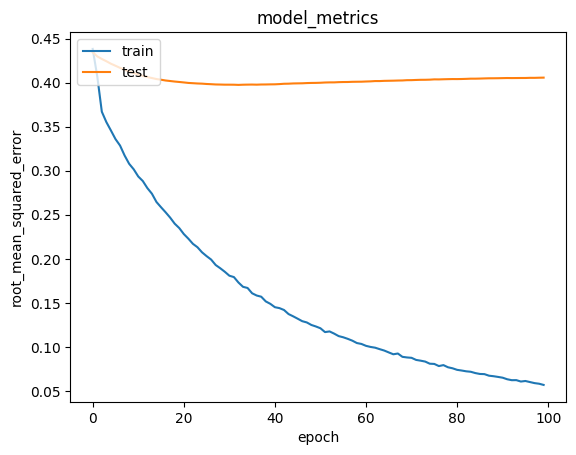

In [82]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Selanjutnya, dilakukan visualisasi performa model selama proses pelatihan menggunakan metrik Root Mean Squared Error (RMSE). Grafik menampilkan perbandingan nilai RMSE antara data latih dan data validasi di setiap epoch. Tujuannya adalah untuk melihat bagaimana error model berubah seiring waktu, serta untuk mengidentifikasi apakah model mengalami overfitting atau tidak.

In [83]:
# Gunakan df yang sudah disampling 10.000 data
book_df = books_new

# Ambil 1 user secara acak dari df 10rb
user_id = df['User-ID'].sample(1).iloc[0]

# Buku-buku yang sudah dibaca user ini (dari 10rb data saja)
books_read_by_user = df[df['User-ID'] == user_id]

# ISBN buku yang belum dibaca user
books_not_read = book_df[~book_df['id'].isin(books_read_by_user.ISBN.values)]['id']

# Ambil hanya buku yang sudah ada di book_to_book_encoded (yaitu dari 10rb data)
books_not_read = list(
    set(books_not_read)
    .intersection(set(book_to_book_encoded.keys()))
)

# Ubah ke format list of list [ [encoded_book_id], ... ]
books_not_read = [[book_to_book_encoded.get(x)] for x in books_not_read]

# Encode user ID
user_encoder = user_to_user_encoded.get(user_id)

# Bentuk array [ [user_id, book_id], ... ]
user_book_array = np.hstack(
    ([[user_encoder]] * len(books_not_read), books_not_read)
)


Sistem menyiapkan data untuk proses prediksi rekomendasi dengan memilih satu pengguna secara acak dan mengidentifikasi buku-buku yang belum pernah dibaca berdasarkan sampel 10.000 data. Buku-buku tersebut kemudian disaring agar hanya mencakup yang telah dikenali oleh model melalui proses encoding. Setelah itu, ID pengguna dan ID buku-buku yang belum dibaca dikonversi ke dalam format array dua dimensi sebagai input bagi model untuk memprediksi rating.

In [84]:
# Prediksi rating user terhadap buku-buku yang belum dibaca
ratings = model.predict(user_book_array).flatten()

# Ambil 10 prediksi rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Ambil ISBN buku yang direkomendasikan (decode dari index)
recommended_book_ids = [
    book_encoded_to_book.get(books_not_read[x][0]) for x in top_ratings_indices
]

# Tampilkan hasil rekomendasi
print('Showing recommendations for user:', user_id)
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)

# Ambil buku dengan rating tertinggi dari user
top_books_user = (
    books_read_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

# Tampilkan informasi buku favorit user
book_df_rows = book_df[book_df['id'].isin(top_books_user)]
for row in book_df_rows.itertuples():
    print(f"{row.title} - {row.author} ({row.publisher})")

print('----' * 8)
print('Top 10 Book Recommendations')
print('----' * 8)

# Ambil detail buku dari rekomendasi
recommended_books = book_df[book_df['id'].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(f"{row.title} - {row.author} ({row.publisher})")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Showing recommendations for user: 170786
Books with high ratings from user
--------------------------------
--------------------------------
Top 10 Book Recommendations
--------------------------------
A Superior Death - Nevada Barr (Harper Mass Market Paperbacks)
Complete Fawlty Towers - John Cleese (Pantheon Books)
Betsy-Tacy and Tib (Betsy-Tacy) - Maud Hart Lovelace (HarperTrophy)
Things Fall Apart - Chinua Achebe (Ballantine Books)
Christmas Box (Christmas Box Trilogy) - Richard Paul Evans (Simon &amp; Schuster)
Cool Coyote Cafe Juice Drinks - Mark Miller (John Wiley &amp; Sons)
I Spy Spooky Night: A Book of Picture Riddles (I Spy Books) - Walter Wick (Scholastic)
Der Erwahlte - Thomas Mann (Fischer Taschenbuch Verlag GmbH)
CRY THE BELOVED COUNTRY (Scribner Classic) - Alan Paton (Scribner)
The Missing Piece (Ursula Nordstrom Book) - Shel Silverstein (HarperCollins)


Setelah data pengguna dan daftar buku yang belum dibaca disiapkan, model yang telah dilatih digunakan untuk memprediksi rating terhadap buku-buku tersebut. Dari hasil prediksi, sistem memilih 10 buku dengan skor tertinggi sebagai rekomendasi. Untuk melengkapi hasilnya, ditampilkan juga daftar buku favorit pengguna berdasarkan rating tertinggi yang pernah ia berikan, disusul dengan 10 rekomendasi buku yang kemungkinan besar akan disukai.